In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import PyMieScatt as ps
import subprocess
import math
import sys
import pandas as pd
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB  # Pas utilisé, cela illustre mon echec de la méthode de Naïve Bayes
from sklearn.cluster import KMeans # Pareil pour la méthode KMeans

indreal, indimg, sig = 1.33, 1E-9, 1.8 # ne pas modifier pour l'instant

lw, ms = 1, 0.02

particle_name = 'water-sigma1.8bae'

On pourra utiliser ces commandes pour se fournir l'ensemble des bibliothèques :

        -conda install -c conda-forge tensorflow
        -pip install "tensorflow<2.11"  Si ça ne marche pas
        -conda activate tf
        -conda env list  Pour voir l’ensemble de vos environnement
        -conda install -c anaconda pandas
        -conda install -c conda-forge pymiescatt
        -conda install -c conda-forge xgboost
        -conda install -c anaconda scikit-learn
        -pip install -U scikit-learn Si la précédente ne fonctionne pas
        -conda update –all Cela évitera les conflicts entre les bibliotèques.
        
        
Afin de mieux comprendre le monde de l'intelligence artificielle [cette KnowMap](https://knowmap.org/) est très bien fait

Nous essaierons de développer le plus de programmes de Machine Learning afin de comparer les différentes méthodes(tant que ces méthodes sont adaptées à notre problème).

In [2]:
def BAE_lognormal_fn(diam, sig, indreal, indimg) :
    Q_1064= ps.Mie_Lognormal(complex(indreal,indimg),1064,sig,diam,1e3,asDict=True, lower=0.1, upper=30000) 
    Q_532=ps.Mie_Lognormal(complex(indreal,indimg),532,sig,diam,1e3,asDict=True, lower=0.1, upper=30000) 
    Q_355=ps.Mie_Lognormal(complex(indreal,indimg),355,sig,diam,1e3,asDict=True, lower=0.1, upper=30000) 

    BAE_1064_532 = -np.log(Q_1064['Bback']/ Q_532['Bback'])/np.log(1064/532)
    BAE_532_355 = -np.log(Q_532['Bback']/ Q_355['Bback'])/np.log(532/355)
    BAE_1064_355 = -np.log(Q_1064['Bback']/ Q_355['Bback'])/np.log(1064/355)

    return BAE_1064_532, BAE_532_355, BAE_1064_355

En recherchant dans la [documentation PyMieScatt](https://pymiescatt.readthedocs.io/en/latest/forward.html#Mie_Lognormal) on peut avoir la dénition de la fonction Mie_Lognormal :
    
$$ n\left(d_p\right)=\frac{N_{\infty}}{\sqrt{2 \pi}} \sum_i^k \frac{\gamma_i}{d_p \ln \sigma_{g_i}} \exp \left\{\frac{\left(\ln d_p-\ln d_{p g_i}\right)^2}{2 \ln ^2 \sigma_{g_i}}\right\} $$
    
where $d_{p}$ is the diameter of the particle (in nm), $n(d_{p})$ is the number of particles of diameter $d_{p}$ (per cubic centimeter), $N_\infty$ is the total number of particles in the distribution, $\sigma_{g_i}$ is the geometric standard deviation of mode $i$, and $d_{pg_i}$ is the geometric mean diameter (in nm) of the ith moment. $\gamma_i$ is a porportionality constant that determines the fraction of total particles in the $i$th moment.
    
La suite étant les calculs des BAE (Backscattering Angstrom Exponent) :

$$\alpha = - \frac{\log \frac{\tau_{\lambda_1}}{\tau_{\lambda_2}}}{\log \frac{\lambda_1}{\lambda_2}}$$


In [3]:
# Importation des données (Calculé par le GMM, ne pas oublier de télécharger les fichiers csv)
df_BAE = np.array(pd.read_csv("BAElognorm.csv"))
df_diam = np.array(pd.read_csv("diam.csv"))

#définitions du jeu de données pour les différents modèles
diam_entree = df_diam[0:714] # Charger les données diamètre

BAE_1064_532 = df_BAE[0:714,0] #On rogne à 715 points car au dessus d'un diamètres de 10^4 cela n'a plus d'intérêt
BAE_532_355 = df_BAE[0:714,1]
BAE_1064_355 = df_BAE[0:714,2]
BAEs = np.array([BAE_1064_532, BAE_532_355, BAE_1064_355]).T

Ceci est l'imporation d'un jeu de données de 715 points calculés avec le serveur du GMM.
Cela nous permets à indreal, indimg et sig constant de faire travailler nos modèle
s avec un nombre importants de points sans tout recalculer.
Nous arretons les points après un diamètre de $10^{-4} nm$ car après cela le sens physique des BAE n'est pas certains

In [31]:
# Importation des données (Calculé par le GMM, ne pas oublier de télécharger les fichiers csv)
df_BAE = np.array(pd.read_csv("BAElognorm.csv"))
df_diam = np.array(pd.read_csv("diam.csv"))

#définitions du jeu de données pour les différents modèles
diam_entree = df_diam[0:714] # Charger les données diamètre

sig_norm = 0.01 # Sigma de notre bruit gaussien

BAE_1064_532 = df_BAE[0:714,0] + np.random.normal(0, sig_norm, 714)
BAE_532_355 = df_BAE[0:714,1] + np.random.normal(0, sig_norm, 714)
BAE_1064_355 = df_BAE[0:714,2] + np.random.normal(0, sig_norm, 714)
BAEs = np.array([BAE_1064_532, BAE_532_355, BAE_1064_355]).T

Dans une version finale, nous apporterons un bruit gaussiens à nos signaux afin de simuler des résultats plus proches de la réalitée.
Cela permettra de mettre un peu plus à l'épreuves nos algorithme et de voir leurs performances

Spoiler : k-NN c'est trop fort ça marchera quand même avec un grand ecart type.
PS : Ne pas oublier de télécharger les fichiers .csv et de les placer dans le même dossier que votre code

In [79]:
# Génération des données (environ 5 mins)
diam_entree = np.logspace(0, 4, 60) # Charger les données diamètre

BAEs = [BAE_lognormal_fn(diam, sig, indreal, indimg) for diam in diam_entree]

BAE_1064_532 = [BAE[0] for BAE in BAEs]
BAE_532_355 = [BAE[1] for BAE in BAEs]
BAE_1064_355 = [BAE[2] for BAE in BAEs]

C:\Users\thoma\anaconda3\envs\tf\lib\site-packages\PyMieScatt\Mie.py:513: UserWarning: Warning: distribution may not be compact on the specified interval. Consider using a higher upper bound.
  warnings.warn("Warning: distribution may not be compact on the specified interval. Consider using a higher upper bound.")


Enfin, une autre méthode pour importer un jeu de données. Elle consiste à générer directement avec la fonction BAE_lognormal_fn le jeu de données. Cela peut être un peu long, pour 60 points il faudra environ 5 minutes d'où la necessité de réaliser un gros jeu de données et de la stocker à part.

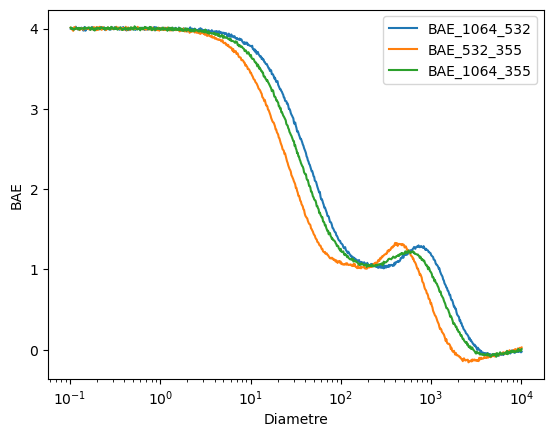

In [32]:
# Affichage des données précédentes
plt.semilogx(diam_entree, BAE_1064_532, label="BAE_1064_532")
plt.semilogx(diam_entree, BAE_532_355, label="BAE_532_355")
plt.semilogx(diam_entree, BAE_1064_355, label="BAE_1064_355")
plt.xlabel("Diametre")
plt.ylabel("BAE")
plt.legend()
plt.show()

Nous affichons ici les BAE du jeu de données précédents. Ce graphique est juste à titre illustratif et ne montre aucun résultats mise à part les courbes des BAE générés.

3125/3125 [==============================] - 2s 515us/step


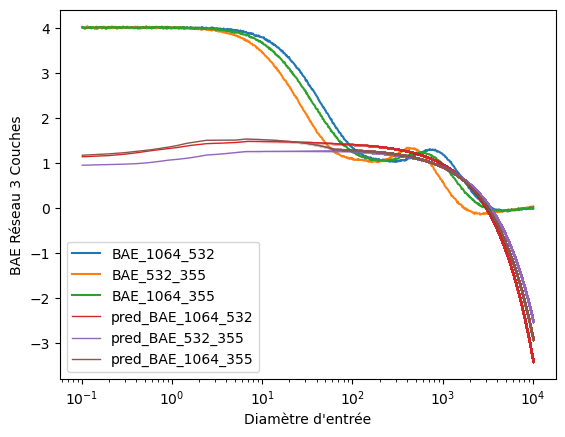

In [33]:
inputs = diam_entree.reshape(-1, 1) # convertir en format pour le réseau de neurones
outputs = np.column_stack((BAE_1064_532, BAE_532_355, BAE_1064_355))

# Modèle du réseau de neurones
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(1,)), # Couche d'entrée
    keras.layers.Dense(32, activation='relu'), # Couche cachée
    keras.layers.Dense(3) # Couche de sortie
])
# Compilation du modèle
model.compile(optimizer='Adam', loss='mean_squared_error') # Adam est le plus efficace pour ce réseau

# Entraînement du modèle
model.fit(inputs, outputs, epochs=100, verbose=0)

# Génération de nouvelles données pour tracer les prédictions
diametre_nouveau = np.linspace(np.min(diam_entree), np.max(diam_entree), 100000)
BAE_nouveau = model.predict(diametre_nouveau.reshape(-1, 1))

# Tracé des prédictions
plt.semilogx(diam_entree, BAEs[:,[0,1,2]], label= ["BAE_1064_532","BAE_532_355","BAE_1064_355"])
plt.semilogx(diametre_nouveau, BAE_nouveau, 'o-', lw = lw, ms = ms, label=["pred_BAE_1064_532","pred_BAE_532_355","pred_BAE_1064_355"])
plt.xlabel("Diamètre d'entrée")
plt.ylabel("BAE Réseau 3 Couches")
plt.legend()
plt.show()

Ce code Python implémente un réseau de neurones à trois couches pour prédire la valeur des BAE

Les étapes importantes sont :

- La conversion des données d'entrée "diam_entree" en un format approprié avec la fonction "reshape(-1, 1)".


- La définition du modèle en utilisant la classe "Sequential" et l'ajout de trois couches : 
    - une couche d'entrée avec 32 neurones et une activation "relu", 
    - une couche cachée avec 32 neurones et une activation "relu"
    - une couche de sortie avec 3 neurones pour les prédictions.
    
    Pour cette partie nous pourrons nous appuyer sur [cette documentation](https://keras.io/api/layers/core_layers/dense/)


- La compilation du modèle avec l'algorithme "Adam" (qui se révelera le plus efficace dans ce cas) et la fonction de coût "mean_squared_error".
[Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.](https://keras.io/api/optimizers/adam/)


- L'entraînement du modèle (100 boucles).


- La génération de nouvelles données pour tracer les prédictions en utilisant la fonction "predict" sur le modèle entraîné.


- Le tracé des prédictions et des données réelles en utilisant la fonction "semilogx" de Matplotlib pour afficher les graphes en échelle logarithmique sur l'axe des x.

Le code montre comment construire et entraîner un réseau de neurones avec Keras pour résoudre un problème de régression.

3125/3125 [==============================] - 2s 535us/step


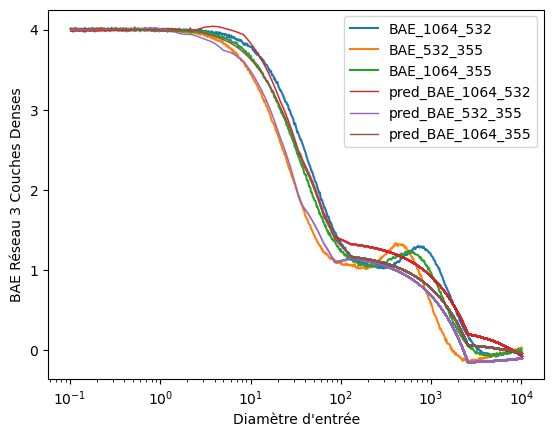

In [36]:
# Séparation des données en entrée et sortie
input_d = np.column_stack((diam_entree, np.full((diam_entree.shape[0], 1), sig),
                              np.full((diam_entree.shape[0], 1), indreal),
                              np.full((diam_entree.shape[0], 1), indimg)))

output_d = np.column_stack((BAE_1064_532, BAE_532_355, BAE_1064_355))

train_input, val_input, train_output, val_output = train_test_split(input_d, output_d, test_size=0.2, random_state=42) 
# Séparer les données

# Création du modèle de réseau de neurones
model = keras.Sequential()
model.add(keras.layers.Dense(32, input_shape=(4,), activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='linear'))

# Compilation du modèle
model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mae'])

# Entraînement du modèle
history = model.fit(train_input, train_output, epochs=100, verbose=0, validation_data=(val_input, val_output))

# Évaluation du modèle
_, train_mae = model.evaluate(train_input, train_output, verbose=0)
_, val_mae = model.evaluate(val_input, val_output, verbose=0)

# Génération de nouvelles données pour tracer les prédictions
diametre_nouveau = np.linspace(np.min(diam_entree), np.max(diam_entree), 100000)
input_nouveau = np.column_stack((diametre_nouveau, np.full((diametre_nouveau.shape[0], 1), sig),
                              np.full((diametre_nouveau.shape[0], 1), indreal),
                              np.full((diametre_nouveau.shape[0], 1), indimg)))
BAE_nouveau = model.predict(input_nouveau)


# Tracé des prédictions
plt.semilogx(diam_entree, BAEs[:,[0,1,2]], label= ["BAE_1064_532","BAE_532_355","BAE_1064_355"])
plt.semilogx(diametre_nouveau, BAE_nouveau, 'o-', lw = lw, ms = ms, label=["pred_BAE_1064_532","pred_BAE_532_355","pred_BAE_1064_355"])
plt.xlabel("Diamètre d'entrée")
plt.ylabel("BAE Réseau 3 Couches Denses")
plt.legend()
plt.show()

- Ce code crée et entraîne un réseau de neurones à base de couches Denses. Il sépare d'abord les données d'entrée et de sortie en utilisant la fonction train_test_split pour créer des ensembles d'entraînement et de validation. Les données d'entrée sont regroupées en une seule colonne avec la fonction column_stack.


- Le réseau de neurones comprend 3 couches :
    - La première couche de 32 neurones avec une fonction d'activation relu (entrée)
    - la deuxième couche de 32 neurones avec une fonction d'activation relu (cachée)
    - la troisième couche de 3 neurones avec une fonction d'activation lineaire. (sortie)


- Le modèle est compilé en utilisant l'optimiseur Adam et la fonction de perte mean squared error. Il y a toujours 100 itérations d'entrainement du modèle.

Erreur d'entraînement : 0.9999889408716696
Erreur de validation : 0.999920921667317


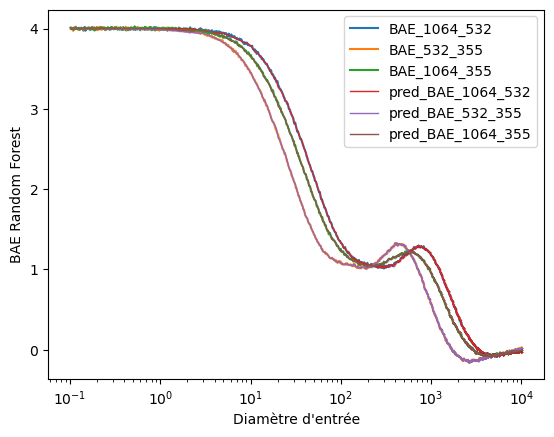

In [37]:
# Séparation des données en entrée et sortie
input_d = np.column_stack((diam_entree, np.full((diam_entree.shape[0], 1), sig),
                              np.full((diam_entree.shape[0], 1), indreal),
                              np.full((diam_entree.shape[0], 1), indimg)))

output_d = np.column_stack((BAE_1064_532, BAE_532_355, BAE_1064_355))

# Séparation des données en ensemble d'entraînement et de validation
train_input, val_input, train_output, val_output = train_test_split(input_d, output_d, test_size=0.2, random_state=42) 

# Création du modèle random forest
model = RandomForestRegressor(n_estimators=100)

# Entraînement du modèle
model.fit(train_input, train_output)

# Évaluation du modèle
train_error = model.score(train_input, train_output)
val_error = model.score(val_input, val_output)
print("Erreur d'entraînement :", train_error)
print("Erreur de validation :", val_error)

# Génération de nouvelles données pour tracer les prédictions
diametre_nouveau = np.linspace(np.min(diam_entree), np.max(diam_entree), 10000)
input_nouveau = np.column_stack((diametre_nouveau, np.full((diametre_nouveau.shape[0], 1), sig),
                              np.full((diametre_nouveau.shape[0], 1), indreal),
                              np.full((diametre_nouveau.shape[0], 1), indimg)))
BAE_nouveau = model.predict(input_nouveau)


# Tracé des prédictions
plt.semilogx(diam_entree, BAEs[:,[0,1,2]], label= ["BAE_1064_532","BAE_532_355","BAE_1064_355"])
plt.semilogx(diametre_nouveau, BAE_nouveau, 'o-', lw = lw, ms = ms, label=["pred_BAE_1064_532","pred_BAE_532_355","pred_BAE_1064_355"])
plt.xlabel("Diamètre d'entrée")
plt.ylabel("BAE Random Forest")
plt.legend()
plt.show()

Ce programme utilise le modèle de Random Forest pour prédire les BAE.


- La première étape consiste à séparer les données en entrée et en sortie en utilisant np.column_stack.


- Ensuite, nous séparons les données en ensembles d'entraînement et de validation à l'aide de la fonction train_test_split. Cette fonction prend en entrée les données d'entrée et de sortie, ainsi qu'un taux de validation de 20% et un random_state fixé à 42.


- Le modèle de forêt aléatoire est créé en utilisant RandomForestRegressor avec n_estimators=100, ce qui signifie que le modèle est formé avec 100 arbres de décision.


- Le modèle est entraîné en utilisant les données d'entraînement avec la méthode fit.


- Les erreurs d'entraînement et de validation sont calculées en utilisant la méthode score avec les données d'entraînement et de validation respectivement.


- De nouvelles données sont générées et utilisées pour faire des prédictions en utilisant la méthode predict sur le modèle entraîné.


Les prochaines descriptions seront plus succincte car les méthodes XGBoost et k-NN respectent exactement le même schéma.

[Vous trouverez la documentation Sk-Learn adapté à ce code ici](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

[21:41:25] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Erreur d'entraînement : 0
Erreur de validation : 0


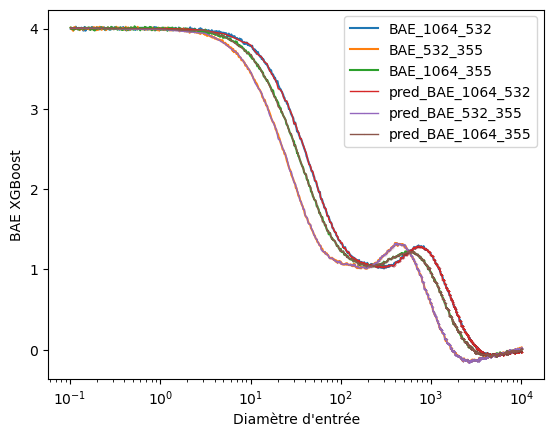

In [38]:
# Séparation des données en entrée et sortie
diam_entree = diam_entree.reshape(-1, 1)
BAE_sortie = np.array(BAEs)

# Séparation des données en ensemble d'entraînement et de validation
train_input, val_input, train_output, val_output = train_test_split(diam_entree, BAEs, test_size=0.2, random_state=42) 

# Conversion des données en format Dmatrix pour XGBoost
dtrain = xgb.DMatrix(train_input, label=train_output)
dval = xgb.DMatrix(val_input, label=val_output)

# Paramétrage de XGBoost
params = {'objective': 'reg:linear',
          'eval_metric': 'rmse',
          'seed': 42}

# Entraînement du modèle
model = xgb.train(params, dtrain, num_boost_round=100)

# Évaluation du modèle
train_error = model.eval(dtrain)[1]
val_error = model.eval(dval)[1]
print("Erreur d'entraînement :", train_error)
print("Erreur de validation :", val_error)

# Génération de nouvelles données pour tracer les prédictions
diametre_nouveau = np.linspace(np.min(diam_entree), np.max(diam_entree), 10000).reshape(-1, 1)
dtest = xgb.DMatrix(diametre_nouveau)
BAE_nouveau = model.predict(dtest)

# Tracé des prédictions
plt.semilogx(diam_entree, BAEs[:,[0,1,2]], label= ["BAE_1064_532","BAE_532_355","BAE_1064_355"])
plt.semilogx(diametre_nouveau, BAE_nouveau, 'o-', lw = lw, ms = ms, label=["pred_BAE_1064_532","pred_BAE_532_355","pred_BAE_1064_355"])
plt.xlabel("Diamètre d'entrée")
plt.ylabel("BAE XGBoost")
plt.legend()
plt.show()

Les données de diamètre d'entrée et de BAE sont séparées en entrées et sorties, en utilisant "diam_entree" et "BAEs". Les données de diamètre sont reshapées pour avoir une forme de (n,1) pour n entrées.

- Les données sont séparées en ensembles d'entraînement et de validation en utilisant "train_test_split".


- Les données sont converties en format "Dmatrix" pour être utilisées par XGBoost.


- Les paramètres de XGBoost sont définis en utilisant le dictionnaire "params".


- Le modèle est formé en utilisant "xgb.train".


- Le modèle est évalué en utilisant "eval" sur les données d'entraînement et de validation.


- Des nouvelles données sont générées pour les prédictions et sont également converties en format "Dmatrix".


- Les nouvelles prédictions sont effectuées en utilisant "predict".

[La documentation de XGBoost est très complète et se trouve à cet l'hyperlien.](https://xgboost.readthedocs.io/en/stable/index.html)

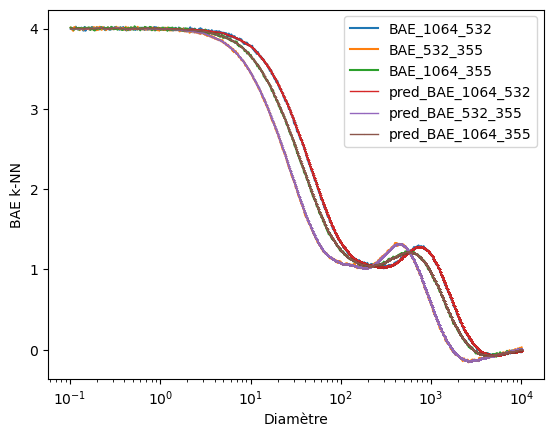

In [39]:
diam_entree = diam_entree.reshape(-1, 1)
BAE_sortie = np.array(BAEs)

# Instancier et entrainer le modèle k-NN
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(diam_entree, BAE_sortie)

# Prédire les valeurs de BAE en utilisant le modèle k-NN
diam_pred = np.linspace(diam_entree.min(), diam_entree.max(), 1000000).reshape(-1, 1)
BAE_pred = knn.predict(diam_pred)

# Afficher les courbes de prédiction
plt.semilogx(diam_entree, BAE_sortie, label= ["BAE_1064_532","BAE_532_355","BAE_1064_355"])
plt.semilogx(diam_pred, BAE_pred, 'o-', lw = lw, ms = ms, label=["pred_BAE_1064_532","pred_BAE_532_355","pred_BAE_1064_355"])
plt.xscale('log')
plt.xlabel('Diamètre')
plt.ylabel('BAE k-NN')
plt.legend()
plt.show()

Ce code effectue une régression non-linéaire à partir d'une variable indépendante (diamètre) en utilisant l'algorithme de voisinage k plus proche (k-NN).

On instancie le modèle k-NN en spécifiant le nombre de voisins à utiliser dans le modèle à n_neighbors = 10. Ce nombre est arbitraire et semble très bien fonctionné. Néanmoins attention à ne pas donner moins de 10 points au départ (sinon y'a pas 10 voisins).

Le modèle k-NN est formé par la méthode fit en passant les données d'entrée et de sortie diam_entree et BAE_sortie.

La méthode predict est ensuite utilisée en utilisant le modèle k-NN formé sur diam_pred.

[Vous trouverez ici la documentation Sk-Learn relative à la méthode k-NN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

C:\Users\thoma\AppData\Local\Temp\ipykernel_7088\435888040.py:6: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 0.7)


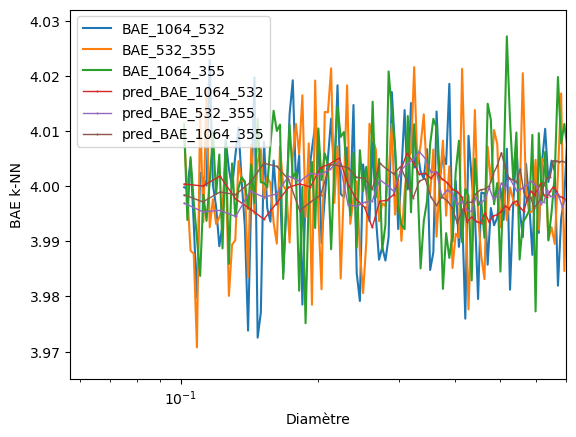

In [40]:
plt.semilogx(diam_entree, BAE_sortie, label= ["BAE_1064_532","BAE_532_355","BAE_1064_355"])
plt.semilogx(diam_pred, BAE_pred, 'o-', lw=1, ms=0.5, label=["pred_BAE_1064_532","pred_BAE_532_355","pred_BAE_1064_355"])
plt.xscale('log')
plt.xlabel('Diamètre')
plt.ylabel('BAE k-NN')
plt.xlim(0, 0.7)
plt.ylim(3.995 - 3*sig_norm, 4.002 + 3*sig_norm)
plt.legend()
plt.show()

Nos craintes se portaient à la convergence des modèles aux niveaux de la jointure des courbes. Nous pouvons voir avec le modèle k-NN et un nombres de points de prédictions suffisament grand qu'il n'y a aucun soucis.
On remarque également qu'en évitant le sur-apprentissage, nous obtenons des résultats tout à fait satisfaisant même avec une perturbation gaussienne.

In [ ]:
start = time.time()

fig, axs = plt.subplots(5, 4)
axs = axs.ravel()
count = 0

indreal = np.linspace(1.33, 1.55, 5)
indimg = np.linspace(1E-3, 1E-6, 4)
sig = np.linspace(1.6, 2.0, 1)

for ir in indreal:
    for ii in indimg:
        for s in sig:
            # Génération des données (environ 5 mins)
            diam_entree = np.logspace(0, 4, 60) # Charger les données diamètre

            BAEs = [BAE_lognormal_fn(diam, s, ir, ii) for diam in diam_entree]

            BAE_1064_532 = [BAE[0] for BAE in BAEs]
            BAE_532_355 = [BAE[1] for BAE in BAEs]
            BAE_1064_355 = [BAE[2] for BAE in BAEs]
            
            diam_entree = diam_entree.reshape(-1, 1)
            BAE_sortie = np.array(BAEs)

            knn = KNeighborsRegressor(n_neighbors=10)
            knn.fit(diam_entree, BAE_sortie)
            
            diam_pred = np.linspace(diam_entree.min(), diam_entree.max(), 1000000).reshape(-1, 1)
            BAE_pred = knn.predict(diam_pred)
            
            axs[count].semilogx(diam_entree, BAE_sortie)
            axs[count].semilogx(diam_pred, BAE_pred, 'o-', lw=0.5, ms=0.01)
            #axs[count].set_xscale('log')
            #axs[count].set_xlabel('Diamètre')
            #axs[count].set_ylabel('BAE k-NN')
            axs[count].set_title('indreal=' + str(ir) + ', indimg=' + str(ii) + ', sig=' + str(s), loc='center', fontsize= 'xx-small')
            #axs[count].legend()
            count += 1
plt.show()
end = time.time()
print(end-start)

Ce programme permets de faire varier les caractéristiques qui étaient au départ fixes. Il fait faire attention aux temps de calculs qui est d'environs 5 minutes par boucles (pour 60 points). On fera donc une grosse simulation sur le serveur du GMM afin de pouvoir stocker et afficher les résultats.

5/5 [==============================] - 0s 1ms/step - loss: 0.0851 - mean_absolute_error: 0.1385
Test accuracy: 0.13850252330303192
31250/31250 [==============================] - 20s 640us/step


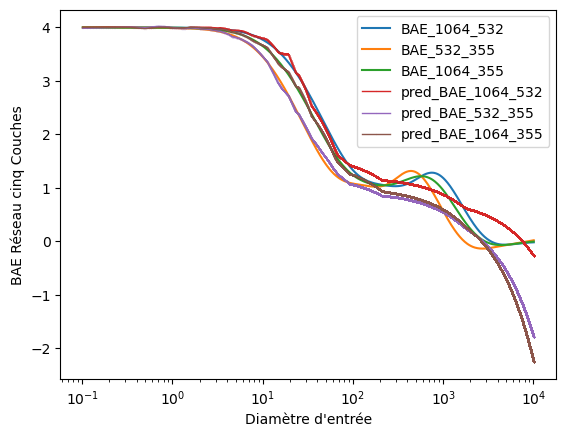

In [46]:
diam_entree = diam_entree.reshape(-1, 1)
BAE_sortie = np.array(BAEs)

# Séparer les données en données d'entraînement et données de test
diam_entree_train, diam_entree_test, BAE_sortie_train, BAE_sortie_test = train_test_split(diam_entree, BAE_sortie, test_size=0.2)

# Définir le modèle
model = keras.Sequential([
    keras.layers.Dense(64, input_shape=(1,), activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3)
])

# Compiler le modèle
model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Entraîner le modèle
history = model.fit(diam_entree_train, BAE_sortie_train, epochs=100, verbose =0, validation_data=(diam_entree_test, BAE_sortie_test))

# Évaluer le modèle sur les données de test
test_loss, test_accuracy = model.evaluate(diam_entree_test, BAE_sortie_test)
print('Test accuracy:', test_accuracy)

# Génération de nouvelles données pour tracer les prédictions
diam_nouveau = np.linspace(diam_entree.min(), diam_entree.max(), 1000000).reshape(-1, 1)
BAE_nouveau = model.predict(diam_nouveau)
diametre_nouveau = diam_nouveau.reshape(1000000)

# Tracé des prédictions
plt.semilogx(diam_entree, BAEs[:,[0,1,2]], label= ["BAE_1064_532","BAE_532_355","BAE_1064_355"])
plt.semilogx(diametre_nouveau, BAE_nouveau, 'o-', lw = lw, ms = ms, label=["pred_BAE_1064_532","pred_BAE_532_355","pred_BAE_1064_355"])
plt.xlabel("Diamètre d'entrée")
plt.ylabel("BAE Réseau cinq Couches")
plt.legend()
plt.show()

Réseau de neuronnes à 5 couches, le programme est plus long à calculer avec des résultats similaires. On Se passera de ce programme pour la suite. Le nombres de couches du réseau de neurones de modifie pas significativement les résultats. 

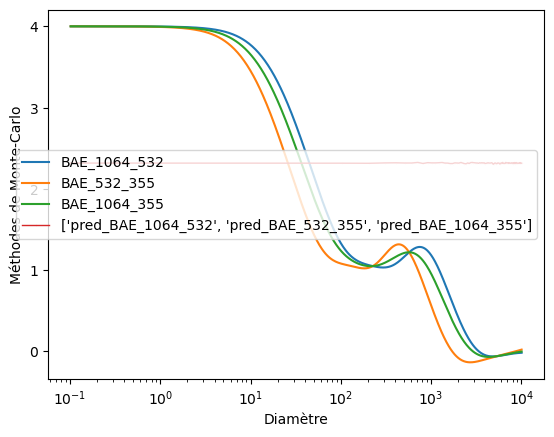

In [5]:
diam_entree = diam_entree.reshape(-1, 1)
BAE_sortie = np.array(BAEs)

def model_predict(diam_entree, BAEs, iterations=100000):
    # La liste pour stocker les prédictions
    predictions = []
    
    for i in range(iterations):
        # Sélectionner aléatoirement une observation à utiliser comme prédicteur
        random_index = np.random.choice(diam_entree.shape[0])
        random_diam = diam_entree[random_index]
        random_BAE = BAEs[random_index]
        
        # Ajouter la prédiction à la liste
        predictions.append(random_BAE)
    
    # Retourner la moyenne des prédictions
    return np.mean(predictions)

diam_nouveau = np.linspace(diam_entree.min(), diam_entree.max(), 100).reshape(-1, 1)
BAE_nouveau = [model_predict(diam_entree, BAEs) for diam in diam_nouveau]

plt.semilogx(diam_entree, BAE_sortie, label= ["BAE_1064_532","BAE_532_355","BAE_1064_355"])
plt.semilogx(diam_nouveau, BAE_nouveau, 'o-', lw = lw, ms = ms, label=["pred_BAE_1064_532","pred_BAE_532_355","pred_BAE_1064_355"])
plt.xscale('log')
plt.xlabel('Diamètre')
plt.ylabel('Méthodes de Monte-Carlo')
plt.legend()
plt.show()

Méthode de Monte-Carlo, à expliquer, et expliquer que c'est pas adapté

C:\Users\thoma\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\thoma\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


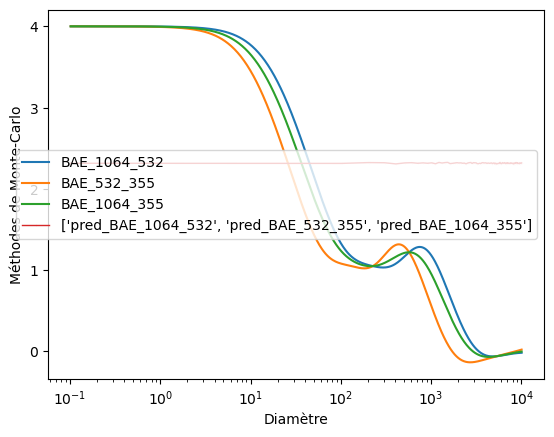

In [6]:
from sklearn.cluster import KMeans

# Entrainer le modèle KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(diam_entree)

# Prédire le cluster pour les nouveaux diamètres
diam_nouveau = np.linspace(diam_entree.min(), diam_entree.max(), 100).reshape(-1, 1)
cluster_predictions = kmeans.predict(diam_nouveau)

# Obtenir les centres des clusters pour chaque cluster
cluster_centers = kmeans.cluster_centers_

# Initialiser la liste pour stocker les prédictions de BAE
BAE_nouveau = []

# Boucle sur les nouveaux diamètres
for i, diam in enumerate(diam_nouveau):
    # Trouver le centre de cluster le plus proche pour ce diamètre
    cluster_index = cluster_predictions[i]
    cluster_center = cluster_centers[cluster_index]
    
    # Obtenir la moyenne des BAE pour ce cluster
    cluster_BAE = np.mean(BAEs[kmeans.labels_ == cluster_index])
    
    # Ajouter la prédiction à la liste
    BAE_nouveau.append(cluster_BAE)
    
diam_nouveau = np.linspace(diam_entree.min(), diam_entree.max(), 100).reshape(-1, 1)
BAE_nouveau = [model_predict(diam_entree, BAEs) for diam in diam_nouveau]

plt.semilogx(diam_entree, BAE_sortie, label= ["BAE_1064_532","BAE_532_355","BAE_1064_355"])
plt.semilogx(diam_nouveau, BAE_nouveau, 'o-', lw = lw, ms = ms, label=["pred_BAE_1064_532","pred_BAE_532_355","pred_BAE_1064_355"])
plt.xscale('log')
plt.xlabel('Diamètre')
plt.ylabel('Méthodes de Monte-Carlo')
plt.legend()
plt.show()

Méthode K-Means à expliquer... d'ailleur j'ai bien l'impression que ça marche pas